⭐ Note: Please activate the 'Index' display on Google Colab for a correct navigation through this notebook

This Google Colab Notebook is available in: https://github.com/erituert/acoustic_information_retrieval/



**Authors**: 

Esther Rituerto González, erituert [at] ing (dot) uc3m (dot) es

Clara Luis Mingueza, cluis [at] pa (dot) uc3m (dot) es

# 1. AudioSET Ontology labels

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import difflib
import seaborn as sn
import matplotlib.pyplot as plt
from google.colab import files
plt.rcParams['font.family'] = "serif"
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

In [10]:
# Variables
in_path = '/content/drive/MyDrive/aasc_tfidf/' # Colab

In [11]:
id_df = pd.read_csv(in_path+'class_labels_indices.csv')
print(id_df.shape)
id_df.head(5)

(527, 3)


,index,mid,display_name
0,0,/m/09x0r,Speech
1,1,/m/05zppz,"Male speech, man speaking"
2,2,/m/02zsn,"Female speech, woman speaking"
3,3,/m/0ytgt,"Child speech, kid speaking"
4,4,/m/01h8n0,Conversation


All the acoustic labels available in Audioset: 527

In [12]:
def correct_formatting(a):
  import re

  # Select only the labels
  out = [item[2:-5] for item in a]
  out = ' '.join(out)

  # Removing " and ' and , and double spaces
  out = out.replace("[","")
  out = out.replace("]","")
  out = out.replace(","," ")
  out = re.sub("\'", "", out)
  out = re.sub("\"", "", out)
  out = ' '.join(word for word in out.split() if len(word)>3)

  return [out]

# 2. WEMAC Audiovisual Stimuli

### 2.1 Read videos information in dataframe

In [13]:
# Read Videos IDs
label_wemacsummer = pd.read_csv('/content/drive/MyDrive/aasc_tfidf/wemac_summer.csv',sep=';')#on_bad_lines='skip')
label_wemacsummer = label_wemacsummer.drop([25],axis=0).reset_index(drop=True) #Because .3gp vid didn't go through yamnet
label_wemacsummer = label_wemacsummer.drop([18],axis=0).reset_index(drop=True) #Because The invisible man video is repeated
emotion_labels_wemac = label_wemacsummer['Discrete emotion']
vid_labels_wemac = label_wemacsummer['Code stimuli']
print(label_wemacsummer.shape)

(43, 13)


#### 2.1.1 Correspondence: Video ID and Emotion

In [14]:
correspondence_wemac = label_wemacsummer[['Code stimuli', 'Discrete emotion', 'GBV interest', 'Title film']]#.drop(columns=['Code number video', 'Unnamed: 11', 'Unnamed: 12'])
correspondence_wemac

,Code stimuli,Discrete emotion,GBV interest,Title film
0,V01,JOY,No,Mamma Mia
1,V02,JOY,No,Don't stop me now (Official Video)
2,V03,JOY,No,Coco
3,V04,JOY,No,Mary Poppins
4,V05,HOPE,No,Efecto Pgmalión (ad TV)
5,V06,SURPRISE,No,The illusionist
6,V07,SURPRISE,No,American Pie
7,V08,ANGER,Yes,SOS Ella: atrapada en una realidad violenta
8,V09,ANGER,Yes,Te doy mis ojos
9,V10,ANGER,No,Harry Potter and the Order of the Phoenix


### 2.2 Read labels corpus file and save content to a DataFrame


In [15]:
# Read labels corpus file and save content to a df
wemac_mids_df = pd.read_csv(in_path+'corpus_mids_220325_wemac_allemotions_all_patchhop_1.csv', header = None, sep='\n')
wemac_mids_df = wemac_mids_df[0].str.split('\s\|\s', expand=True)
wemac_mids_df = wemac_mids_df.drop([18],axis=0).reset_index(drop=True) #Because The invisible man video is repeated
print(wemac_mids_df.shape)
wemac_mids_df.head()

(43, 1)


,0
0,['/m/015lz1 /m/01c194 /m/04rlf /m/074ft /m/03r...
1,['/m/09x0r /m/0463cq4 /m/015lz1 /m/01c194 /m/0...
2,['/m/09x0r /m/01j3sz /m/015lz1 /m/06h7j /m/0jb...
3,['/m/09x0r /m/07p6fty /m/07q4ntr /m/07rwj3x /m...
4,['/m/04rlf /m/05148p4 /t/dd00031 /t/dd00034 /m...


#### 2.2.1 Get duration of WEMAC Audiovisual stimuli (videos, in seconds)

In [16]:
def get_duration(df):
  len_list = []
  for i in range(0,len(df)):
    row = df.iloc[i][0]
    if (i <= 17):
      len_list.append(len(row.split(', \''+str(i+1)+'\''))-1)
    else:
      len_list.append(len(row.split(', \''+str(i+2)+'\''))-1)
  return len_list

In [17]:
wemac_lengths_list = get_duration(wemac_mids_df)
print(wemac_lengths_list)

[87, 102, 52, 89, 64, 76, 102, 64, 61, 120, 47, 120, 94, 141, 81, 124, 123, 65, 29, 77, 113, 114, 88, 75, 81, 96, 50, 70, 68, 80, 97, 46, 103, 120, 101, 66, 74, 61, 81, 103, 29, 86, 91]


In [18]:
new_wemac_mids_list = []

for i in range(0,len(wemac_mids_df)):
  new_wemac_mids_list.append(correct_formatting(wemac_mids_df.iloc[i]))

In [19]:
new_wemac_mids_df = pd.DataFrame(data = new_wemac_mids_list, columns = ['labels'])

In [20]:
new_wemac_mids_df.head(5)

,labels
0,/m/015lz1 /m/01c194 /m/04rlf /m/074ft /m/03r5q...
1,/m/09x0r /m/0463cq4 /m/015lz1 /m/01c194 /m/02f...
2,/m/09x0r /m/01j3sz /m/015lz1 /m/06h7j /m/0jbk ...
3,/m/09x0r /m/07p6fty /m/07q4ntr /m/07rwj3x /m/0...
4,/m/04rlf /m/05148p4 /t/dd00031 /t/dd00034 /m/0...


### 2.3 Get TF-IDF of WEMAC videos

In [21]:
#TF + TFIDF MIDs
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
countVectorizer = CountVectorizer()
tfIdfTransformer = TfidfTransformer(use_idf=True)
wordCount = countVectorizer.fit_transform(new_wemac_mids_df['labels'])
wordCount_wemac = wordCount
new_TfIdf = tfIdfTransformer.fit_transform(wordCount)

In [22]:
# Print idf matrix
#tfIdfTransformer.idf_

In [23]:
print(new_TfIdf.shape) 

(43, 351)


All acoustic labels available in WEMAC videos: 351

In [24]:
# MIDS to strings
df_tfidf_labels_wemac = []
for feature in countVectorizer.get_feature_names():
  #print(feature)
  match = difflib.get_close_matches(str(feature), list(id_df['mid']), n=1, cutoff=0.7)
  string_match = id_df.loc[id_df['mid'] == ''.join(match), 'display_name']
  #print(''.join(match))
  df_tfidf_labels_wemac.append(''.join(string_match))

print(np.shape(df_tfidf_labels_wemac))
print(df_tfidf_labels_wemac)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(351,)
['Wild animals', 'Motor vehicle (road)', 'Ambulance (siren)', 'Fire engine, fire truck (siren)', 'Toothbrush', 'Sink (filling or washing)', 'Aircraft engine', 'Explosion', 'Change ringing (campanology)', 'Dial tone', 'Singing', 'Bird', 'Basketball bounce', 'Subway, metro, underground', 'Bicycle', 'Boat, Water vehicle', 'Sawing', 'Reverberation', 'Cough', 'Bus', 'Mantra', 'Drill', 'Snoring', 'Railroad car, train wagon', 'Stomach rumble', 'Tapping (guitar technique)', 'Bee, wasp, etc.', 'Engine knocking', 'Scratching (performance technique)', 'Ringtone', 'Sneeze', 'Laughter', 'Chainsaw', 'Heart sounds, heartbeat', 'Heart murmur', 'Echo', 'Toilet flush', 'Vibration', 'Scissors', 'Computer keyboard', 'Printer', 'Zipper (clothing)', 'Yodeling', 'Sine wave', 'Whistling', 'Clock', 'Smoke detector, smoke alarm', 'Lawn mower', 'Busy signal', 'Canidae, dogs, wolves', 'Bird vocalization, bird call, bird song', 'Cutlery, silverware', 'Sanding', 'Coin (dropping)', 'Cash register', 'Finger sn

In [25]:
df_tfidf = pd.DataFrame(new_TfIdf.todense(), columns=df_tfidf_labels_wemac)#, columns=["TF-IDF"]) # Aquí estaba cogiendo solo la primera fila (primer video de wemac). lo he cambiado para que sean todos
bbdlab_tfidf = df_tfidf # This is the 'sparse' tdidf bbdlab matrix

print(bbdlab_tfidf.shape)
bbdlab_tfidf.head()

(43, 351)


,Wild animals,Motor vehicle (road),Ambulance (siren),"Fire engine, fire truck (siren)",Toothbrush,Sink (filling or washing),Aircraft engine,Explosion,Change ringing (campanology),Dial tone,...,Boing,"Inside, small room","Inside, large room or hall","Inside, public space","Outside, urban or manmade","Outside, rural or natural",Engine starting,Car passing by,Children shouting,Whimper (dog)
0,0.000000,0.015111,0.0,0.0,0.0,0.00000,0.0,0.016190,0.000000,0.0,...,0.0,0.008990,0.229235,0.045333,0.037631,0.027589,0.0,0.000000,0.045819,0.000000
1,0.012560,0.007815,0.0,0.0,0.0,0.00000,0.0,0.016746,0.000000,0.0,...,0.0,0.076712,0.139475,0.015630,0.036491,0.032103,0.0,0.000000,0.000000,0.000000
2,0.022539,0.031555,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,...,0.0,0.084474,0.206491,0.115700,0.206274,0.144026,0.0,0.000000,0.159463,0.012375
3,0.067548,0.033947,0.0,0.0,0.0,0.01427,0.0,0.031176,0.000000,0.0,...,0.0,0.164449,0.298604,0.261880,0.335140,0.203646,0.0,0.011686,0.000000,0.005706
4,0.000000,0.062460,0.0,0.0,0.0,0.00000,0.0,0.000000,0.026366,0.0,...,0.0,0.241525,0.102184,0.010410,0.048608,0.038012,0.0,0.012543,0.000000,0.000000


### 2.4 Get top videos per acoustic label
This function returns the videos in order of greater percentage of detection of a specific acoustic label given, on them

In [26]:
 def percentage_top_videos_per_label(wordCount,vid_lengths,vid_ids,emotion_labels,acoustic_labels,label_name):
  percentages =  wordCount.todense() / np.asarray(vid_lengths)[:,None]
  perc_df = pd.DataFrame(data = percentages, columns = acoustic_labels)
  perc_df['Code stimuli'] = vid_ids
  perc_df['Discrete emotion'] = emotion_labels
  all_labels_perc_df = perc_df.sort_values(by=[label_name], ascending=False)
  label_perc_df = all_labels_perc_df[['Code stimuli','Discrete emotion', label_name]]
  return label_perc_df

Example using the acoustic label "Music". The function returns which videos have a greater percentage of "Music" acoustic labels detected

In [27]:
label_to_determine = 'Music'
perc_music_df = percentage_top_videos_per_label(wordCount,wemac_lengths_list,label_wemacsummer['Code stimuli'], label_wemacsummer['Discrete emotion'],df_tfidf_labels_wemac,label_to_determine)
perc_music_df.head(10)

,Code stimuli,Discrete emotion,Music
42,V45,TENDERNESS,1.000000
29,V32,DISGUST,1.000000
39,V42,CALM,1.000000
38,V41,CALM,1.000000
4,V05,HOPE,1.000000
36,V39,CALM,1.000000
34,V37,TENDERNESS,1.000000
32,V35,SADNESS,1.000000
31,V34,SADNESS,0.978261
0,V01,JOY,0.977011


### 2.5 Get top acoustic labels per video
This function returns the acoustic labels in order of greater percentage of detection for a specific video given

In [28]:
def percentage_top_labels_per_video(wordCount,vid_lengths,vid_ids,acoustic_labels,vid_id):
  percentages =  wordCount.todense() / np.asarray(vid_lengths)[:,None]

  perc_df = pd.DataFrame(data = percentages.T, index = acoustic_labels, columns = vid_ids)

  vid_perc_df = perc_df[vid_id].sort_values(ascending=False)
  return vid_perc_df

Example using the video number 8. The function returns the top percentage of acoustic labels detected

In [29]:
vid_to_determine = 'V08'
perc_v08_df = percentage_top_labels_per_video(wordCount,wemac_lengths_list,label_wemacsummer['Code stimuli'],df_tfidf_labels_wemac,vid_to_determine)
perc_v08_df.head(10)

Speech                        0.921875
Inside, small room            0.921875
Inside, large room or hall    0.687500
Laughter                      0.281250
Music                         0.250000
Television                    0.156250
Animal                        0.156250
Chuckle, chortle              0.140625
Domestic animals, pets        0.140625
Silence                       0.125000
Name: V08, dtype: float64

### 2.6 Cosine Distance WEMAC Videos

In [30]:
# COSINE DISTANCE
# Note: similarity = 1- cos_dist
cosine_dist_wemac = 1-pairwise_distances(bbdlab_tfidf, Y=bbdlab_tfidf, metric="cosine")
print(cosine_dist_wemac.shape)

(43, 43)


#### 2.6.1 Heatmap sorted by alphabetical emotions


In [31]:
index_emotion_labels_alphabetical = sorted(range(len(emotion_labels_wemac)), key=lambda k: emotion_labels_wemac[k])

In [32]:
sorted_emotion_labels = emotion_labels_wemac.iloc[index_emotion_labels_alphabetical].values
sorted_vid_labels_wemac = vid_labels_wemac.iloc[index_emotion_labels_alphabetical].values

In [33]:
rearranged_cosine_dist_wemac_1 = cosine_dist_wemac[:,index_emotion_labels_alphabetical] # columns
rearranged_cosine_dist_wemac_2 = rearranged_cosine_dist_wemac_1[index_emotion_labels_alphabetical,:] # rows

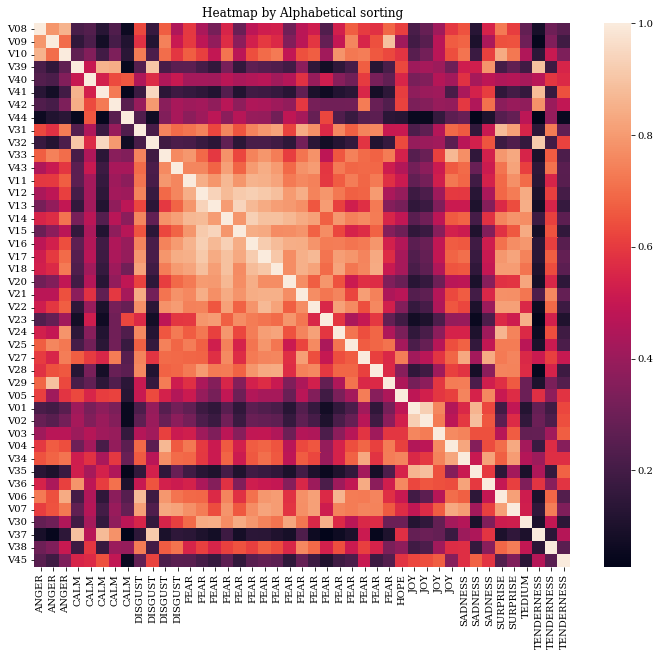

In [34]:
plt.figure(figsize = (12,10))
plt.title('Heatmap by Alphabetical sorting')
sn.heatmap(rearranged_cosine_dist_wemac_2, annot=False, xticklabels=sorted_emotion_labels, yticklabels=sorted_vid_labels_wemac)

#### 2.6.2 Heatmap sorted by mean energy of each embedding

In [35]:
index_emotion_labels = np.argsort(np.mean(cosine_dist_wemac,axis=0))

In [36]:
sorted_emotion_labels = emotion_labels_wemac.iloc[index_emotion_labels].values
sorted_vid_labels_wemac = vid_labels_wemac.iloc[index_emotion_labels].values

In [37]:
rearranged_cosine_dist_wemac3 = cosine_dist_wemac[:,index_emotion_labels] #columns
rearranged_cosine_dist_wemac4 = rearranged_cosine_dist_wemac3[index_emotion_labels,:] #rows

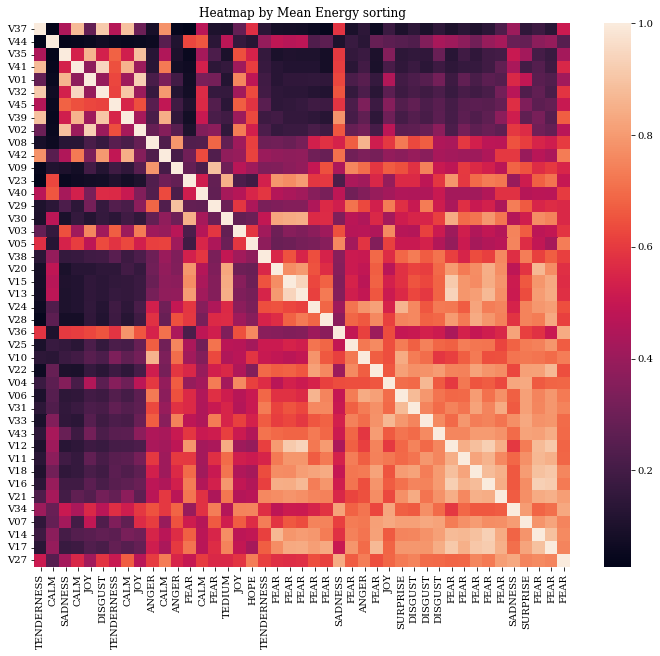

In [38]:
plt.figure(figsize = (12,10))
plt.title('Heatmap by Mean Energy sorting')
sn.heatmap(rearranged_cosine_dist_wemac4, annot=False, xticklabels=sorted_emotion_labels, yticklabels=sorted_vid_labels_wemac)

#### 2.6.3 Heatmap sorted manually by visual analysis
- Emotions order: Anger, Disgust, Fear, Surprise, Tedium, Joy, Calm, Tenderness, Hope, Sadness
- Vid order (with respect to Alphabetical order):
      Anger: 1 2 3
      Disgust: 1 3 4 2
      Fear: V13 V15 V20 V23 V28 then the rest
      Surprise: 1 2
      Tedium: 1
      Joy: 3 1 4 2
      Calm: 2 4 1 3 5
      Tenderness: 1 3 2
      Hope: 1
      Sadness: 1 3 2


In [39]:
pd.set_option('display.max_columns', None)
correspondence_wemac[['Code stimuli', 'Discrete emotion']].loc[index_emotion_labels_alphabetical].T

,7,8,9,36,37,38,39,41,28,29,30,40,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,4,0,1,2,3,31,32,33,5,6,27,34,35,42
Code stimuli,V08,V09,V10,V39,V40,V41,V42,V44,V31,V32,V33,V43,V11,V12,V13,V14,V15,V16,V17,V18,V20,V21,V22,V23,V24,V25,V27,V28,V29,V05,V01,V02,V03,V04,V34,V35,V36,V06,V07,V30,V37,V38,V45
Discrete emotion,ANGER,ANGER,ANGER,CALM,CALM,CALM,CALM,CALM,DISGUST,DISGUST,DISGUST,DISGUST,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,HOPE,JOY,JOY,JOY,JOY,SADNESS,SADNESS,SADNESS,SURPRISE,SURPRISE,TEDIUM,TENDERNESS,TENDERNESS,TENDERNESS


In [40]:
#                              < anger> < disgust    > < fear                                                            > <surpr><tedium> < joy    > < calm            > < tenderness> <hope> <sadness >
index_emotion_labels_manual = [7, 8, 9, 28, 30, 29, 40, 12, 14, 18, 21, 25, 10, 11, 13, 15, 16, 17, 19, 20, 22, 23, 24, 26, 5, 6,  27    ,  2, 0, 3, 1, 37, 39, 36, 38, 41, 34, 42, 35,  4     , 31, 33, 32 ]
sorted_emotion_labels = emotion_labels_wemac.iloc[index_emotion_labels_manual].values

In [41]:
sorted_vid_labels_wemac = vid_labels_wemac.iloc[index_emotion_labels_manual].values

In [42]:
rearranged_cosine_dist_wemac5 = cosine_dist_wemac[:,index_emotion_labels_manual] # columns
rearranged_cosine_dist_wemac6 = rearranged_cosine_dist_wemac5[index_emotion_labels_manual,:] # rows

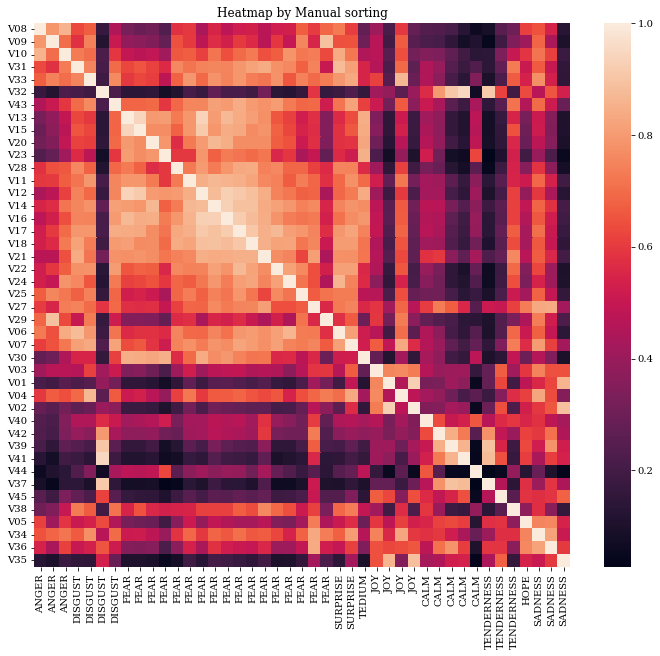

In [43]:
plt.figure(figsize = (12,10))
plt.title('Heatmap by Manual sorting')
sn.heatmap(rearranged_cosine_dist_wemac6, annot=False, xticklabels=sorted_emotion_labels, yticklabels=sorted_vid_labels_wemac)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

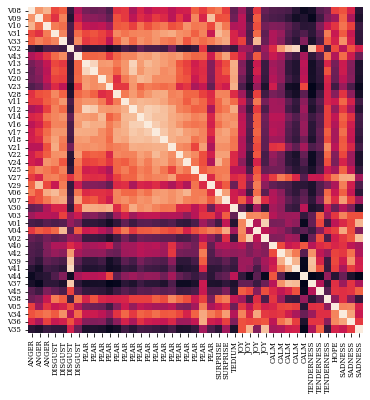

In [44]:
plt.figure(figsize = (6,6))
#plt.title('Heatmap by Manual sorting')
sn.heatmap(rearranged_cosine_dist_wemac6, annot=False, xticklabels=sorted_emotion_labels, yticklabels=sorted_vid_labels_wemac,cbar=False)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig("heatmap_manual_vids.pdf", format="pdf", bbox_inches="tight")
files.download("heatmap_manual_vids.pdf")

### 2.7 Removing outliers after videos inspection analysis (with respect to manual sorting)

In [45]:
# visual outliers = V32 DISGUST, V27 FEAR, V04 JOY, V44 CALM, V38 TENDERNESS, V35 SADNESS
vid_visual_outliers  = ['V32', 'V27', 'V04', 'V44', 'V38', 'V35']
idx_visual_outliers = []
for j, vid in enumerate(vid_visual_outliers):
  visual_outlier = correspondence_wemac[correspondence_wemac['Code stimuli'] == vid].index.values[0]
  idx_visual_outliers.append(visual_outlier)
print(idx_visual_outliers)

[29, 24, 3, 41, 35, 32]


In [46]:
index_emotion_labels_manual_wo = [item for item in index_emotion_labels_manual if item not in idx_visual_outliers]

In [47]:
sorted_emotion_labels_wo = emotion_labels_wemac.iloc[index_emotion_labels_manual_wo].values

In [48]:
sorted_vid_labels_wemac_wo = vid_labels_wemac.iloc[index_emotion_labels_manual_wo].values

In [49]:
rearranged_cosine_dist_wemac_wo1 = cosine_dist_wemac[:,index_emotion_labels_manual_wo] # columns
rearranged_cosine_dist_wemac_wo2 = rearranged_cosine_dist_wemac_wo1[index_emotion_labels_manual_wo,:] # rows

#### 2.7.1 Heatmap sorted manually by visual analysis without outliers


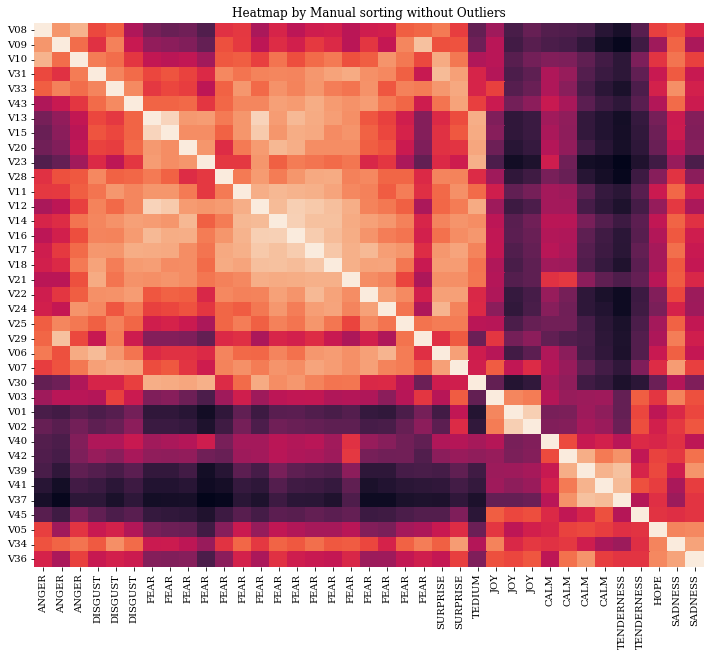

In [50]:
plt.figure(figsize = (12,10))
plt.title('Heatmap by Manual sorting without Outliers')
sn.heatmap(rearranged_cosine_dist_wemac_wo2, annot=False, xticklabels=sorted_emotion_labels_wo, yticklabels=sorted_vid_labels_wemac_wo, cbar=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

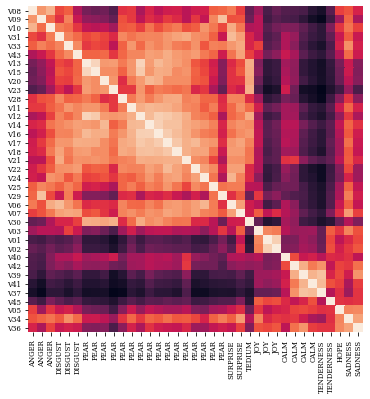

In [51]:
plt.figure(figsize = (6,6))
sn.heatmap(rearranged_cosine_dist_wemac_wo2, annot=False, xticklabels=sorted_emotion_labels_wo, yticklabels=sorted_vid_labels_wemac_wo,cbar=False)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig("heatmap_manual_vids_wo.pdf", format="pdf", bbox_inches="tight")
files.download("heatmap_manual_vids_wo.pdf")

### 2.8 Mean embeddings per emotion

In [52]:
len(index_emotion_labels_manual_wo)

37

In [53]:
print(index_emotion_labels_manual_wo)

[7, 8, 9, 28, 30, 40, 12, 14, 18, 21, 25, 10, 11, 13, 15, 16, 17, 19, 20, 22, 23, 26, 5, 6, 27, 2, 0, 1, 37, 39, 36, 38, 34, 42, 4, 31, 33]


In [54]:
correspondence_wemac_wo = correspondence_wemac[['Code stimuli', 'Discrete emotion']].loc[index_emotion_labels_manual_wo]

In [55]:
print(correspondence_wemac_wo.shape)
correspondence_wemac_wo.T.head()

(37, 2)


,7,8,9,28,30,40,12,14,18,21,25,10,11,13,15,16,17,19,20,22,23,26,5,6,27,2,0,1,37,39,36,38,34,42,4,31,33
Code stimuli,V08,V09,V10,V31,V33,V43,V13,V15,V20,V23,V28,V11,V12,V14,V16,V17,V18,V21,V22,V24,V25,V29,V06,V07,V30,V03,V01,V02,V40,V42,V39,V41,V37,V45,V05,V34,V36
Discrete emotion,ANGER,ANGER,ANGER,DISGUST,DISGUST,DISGUST,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,FEAR,SURPRISE,SURPRISE,TEDIUM,JOY,JOY,JOY,CALM,CALM,CALM,CALM,TENDERNESS,TENDERNESS,HOPE,SADNESS,SADNESS


In [56]:
bbdlab_tfidf_sorted_wo = bbdlab_tfidf.iloc[index_emotion_labels_manual_wo]
bbdlab_tfidf_sorted_wo = bbdlab_tfidf_sorted_wo.reset_index()
bbdlab_tfidf_sorted_wo = bbdlab_tfidf_sorted_wo.rename(columns={"index": "original_index"})
print(bbdlab_tfidf_sorted_wo.shape)
bbdlab_tfidf_sorted_wo.head()

(37, 352)


,original_index,Wild animals,Motor vehicle (road),Ambulance (siren),"Fire engine, fire truck (siren)",Toothbrush,Sink (filling or washing),Aircraft engine,Explosion,Change ringing (campanology),Dial tone,Singing,Bird,Basketball bounce,"Subway, metro, underground",Bicycle,"Boat, Water vehicle",Sawing,Reverberation,Cough,Bus,Mantra,Drill,Snoring,"Railroad car, train wagon",Stomach rumble,Tapping (guitar technique),"Bee, wasp, etc.",Engine knocking,Scratching (performance technique),Ringtone,Sneeze,Laughter,Chainsaw,"Heart sounds, heartbeat",Heart murmur,Echo,Toilet flush,Vibration,Scissors,Computer keyboard,Printer,Zipper (clothing),Yodeling,Sine wave,Whistling,Clock,"Smoke detector, smoke alarm",Lawn mower,Busy signal,"Canidae, dogs, wolves","Bird vocalization, bird call, bird song","Cutlery, silverware",Sanding,Coin (dropping),Cash register,Finger snapping,Air conditioning,Train horn,Applause,Silence,Fire,Fart,"Ratchet, pawl","Telephone dialing, DTMF",Door,"Beep, bleep",Humming,"Electric shaver, electric razor","Water tap, faucet","Propeller, airscrew",Car alarm,Engine,Filing (rasp),Hiccup,Blender,Reversing beeps,"Motorboat, speedboat",Effects unit,Whispering,Mechanical fan,Sliding door,Fusillade,Buzzer,Typing,Whale vocalization,"Gunshot, gunfire","Waves, surf",Glass,"Chewing, mastication","Ice cream truck, ice cream van",Bathtub (filling or washing),Emergency vehicle,Siren,Hammer,Wind,Jackhammer,"Burping, eructation",Screaming,Crowd,Jingle (music),Keys jangling,Insect,Hair dryer,Doorbell,Jet engine,"Crying, sobbing",Alarm clock,Motorcycle,"Dishes, pots, and pans",Roar,Electric toothbrush,Foghorn,"Power windows, electric windows",Liquid,Police car (siren),Music,Mouse,Crow,Machine gun,Train whistle,Keyboard (musical),Cheering,"Rowboat, canoe, kayak","Bird flight, flapping wings",Ocean,Rattle (instrument),Shuffling cards,"Air horn, truck horn",Pulleys,Cupboard open or close,"Domestic animals, pets",Skateboard,Environmental noise,Rapping,Radio,Rail transport,Run,Steam whistle,"Rodents, rats, mice",Rain,Ship,Steam,Mains hum,Cap gun,Song,Snake,Sonar,Single-lens reflex camera,Television,Telephone,Field recording,Train,Tools,Chorus effect,Wheeze,Shout,Slosh,Zing,Fill (with liquid),Sizzle,Throbbing,Idling,"Walk, footsteps",Breaking,Chop,Biting,Rub,"Chirp, tweet",Rumble,Ding,"Smash, crash",Buzz,Splinter,Crushing,Sigh,Chopping (food),Telephone bell ringing,Alarm,Sniff,"Trickle, dribble",Bouncing,Pour,Pulse,Stir,Pump (liquid),Bang,Eruption,Flap,Pant,Crackle,Snort,"Accelerating, revving, vroom",Bellow,Squeak,"Chink, clink",Scratch,Clicking,Tap,Tearing,"Jingle, tinkle","Hubbub, speech noise, speech babble",Creak,Tick-tock,Tick,Spray,Squish,Clatter,Rattle,"Thump, thud",Boom,Crack,"Burst, pop",Scrape,Toot,Shuffle,"Wail, moan",Ping,Rustle,Plop,Whimper,Truck,Raindrop,Patter,Grunt,Knock,Caw,Drip,Giggle,Ding-dong,Coo,Hoot,Whip,Hum,"Whack, thwack",Static,"Chuckle, chortle",Slam,Chatter,Skidding,Shatter,"Whoosh, swoosh, swish",Thunk,"Splash, splatter",Clang,Whoop,Clickety-clack,"Slap, smack",Squeal,Snicker,Gasp,Crunch,Groan,Whir,Roll,Belly laugh,Yell,Croak,Gurgling,Squawk,Cacophony,Vehicle,Writing,Water,Wood,"Dental drill, dentist's drill",Sidetone,"Vehicle horn, car horn, honking",Gargling,Noise,Helicopter,Owl,Mosquito,Frog,Rustling leaves,Speech,Cricket,Artillery fire,Power tool,Harmonic,Electronic tuner,"Traffic noise, roadway noise",Sound effect,Typewriter,Fire alarm,"Roaring cats (lions, tigers)","Livestock, farm animals, working animals",White noise,Pink noise,"Fixed-wing aircraft, airplane",Vacuum cleaner,Civil defense siren,Arrow,Throat clearing,Boiling,Camera,Frying (food),Drawer open or close,Microwave oven,Distortion,Fireworks,Air brake,"Pigeon, dove","Fly, housefly",Tire squeal,Chirp tone,"Sailboat, sailing ship",Waterfall,Stream,Thunderstorm,Animal,Car,Aircraft,Hands,Whistle,Clapping,Gears,Sewing machine,"Race car, auto racing",Breathing,Thunder,Firecracker,Baby laughter,"Baby cry, infant cry",Child singing,Synthetic singing,Children 

In [57]:
a = correspondence_wemac_wo['Discrete emotion']
indexes = np.unique(a, return_index=True)[1]
emotions = [a.iloc[index] for index in sorted(indexes)]

In [58]:
emotions

['ANGER',
 'DISGUST',
 'FEAR',
 'SURPRISE',
 'TEDIUM',
 'JOY',
 'CALM',
 'TENDERNESS',
 'HOPE',
 'SADNESS']

In [59]:
correspondence_wemac_sorted_wo = correspondence_wemac_wo.reset_index().rename(columns={"index": "original_index"})
correspondence_wemac_sorted_wo.head(37)

,original_index,Code stimuli,Discrete emotion
0,7,V08,ANGER
1,8,V09,ANGER
2,9,V10,ANGER
3,28,V31,DISGUST
4,30,V33,DISGUST
5,40,V43,DISGUST
6,12,V13,FEAR
7,14,V15,FEAR
8,18,V20,FEAR
9,21,V23,FEAR


To create emotion embeddings we perform the mean of the tf-idf matrix

In [60]:
emotion_embeddings_df_bbdlab = pd.DataFrame(data = np.zeros((10, 352)))
for id, emotion in enumerate(emotions):
  emotion_aux = [correspondence_wemac_sorted_wo['Discrete emotion'] == emotion][0].values
  emotion_idx = correspondence_wemac_sorted_wo[emotion_aux].index.values
  print(emotion_idx)
  emotion_rows = bbdlab_tfidf_sorted_wo.iloc[emotion_idx]
  #print(emotion_rows)
  #print(np.mean(emotion_rows, axis=0).shape)
  emotion_embeddings_df_bbdlab.iloc[id] = np.mean(emotion_rows, axis=0)

[0 1 2]
[3 4 5]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[22 23]
[24]
[25 26 27]
[28 29 30 31]
[32 33]
[34]
[35 36]


In [61]:
emotion_embeddings_df_bbdlab_ = emotion_embeddings_df_bbdlab.drop(columns = 0)
emotion_embeddings_df_bbdlab_ = emotion_embeddings_df_bbdlab_.set_axis(df_tfidf_labels_wemac, axis=1, inplace=False)
emotion_embeddings_df_bbdlab_ = emotion_embeddings_df_bbdlab_.set_axis(emotions, axis=0, inplace=False)

In [62]:
print(emotion_embeddings_df_bbdlab_.shape)

(10, 351)


In [63]:
emotion_embeddings_df_bbdlab_

,Wild animals,Motor vehicle (road),Ambulance (siren),"Fire engine, fire truck (siren)",Toothbrush,Sink (filling or washing),Aircraft engine,Explosion,Change ringing (campanology),Dial tone,Singing,Bird,Basketball bounce,"Subway, metro, underground",Bicycle,"Boat, Water vehicle",Sawing,Reverberation,Cough,Bus,Mantra,Drill,Snoring,"Railroad car, train wagon",Stomach rumble,Tapping (guitar technique),"Bee, wasp, etc.",Engine knocking,Scratching (performance technique),Ringtone,Sneeze,Laughter,Chainsaw,"Heart sounds, heartbeat",Heart murmur,Echo,Toilet flush,Vibration,Scissors,Computer keyboard,Printer,Zipper (clothing),Yodeling,Sine wave,Whistling,Clock,"Smoke detector, smoke alarm",Lawn mower,Busy signal,"Canidae, dogs, wolves","Bird vocalization, bird call, bird song","Cutlery, silverware",Sanding,Coin (dropping),Cash register,Finger snapping,Air conditioning,Train horn,Applause,Silence,Fire,Fart,"Ratchet, pawl","Telephone dialing, DTMF",Door,"Beep, bleep",Humming,"Electric shaver, electric razor","Water tap, faucet","Propeller, airscrew",Car alarm,Engine,Filing (rasp),Hiccup,Blender,Reversing beeps,"Motorboat, speedboat",Effects unit,Whispering,Mechanical fan,Sliding door,Fusillade,Buzzer,Typing,Whale vocalization,"Gunshot, gunfire","Waves, surf",Glass,"Chewing, mastication","Ice cream truck, ice cream van",Bathtub (filling or washing),Emergency vehicle,Siren,Hammer,Wind,Jackhammer,"Burping, eructation",Screaming,Crowd,Jingle (music),Keys jangling,Insect,Hair dryer,Doorbell,Jet engine,"Crying, sobbing",Alarm clock,Motorcycle,"Dishes, pots, and pans",Roar,Electric toothbrush,Foghorn,"Power windows, electric windows",Liquid,Police car (siren),Music,Mouse,Crow,Machine gun,Train whistle,Keyboard (musical),Cheering,"Rowboat, canoe, kayak","Bird flight, flapping wings",Ocean,Rattle (instrument),Shuffling cards,"Air horn, truck horn",Pulleys,Cupboard open or close,"Domestic animals, pets",Skateboard,Environmental noise,Rapping,Radio,Rail transport,Run,Steam whistle,"Rodents, rats, mice",Rain,Ship,Steam,Mains hum,Cap gun,Song,Snake,Sonar,Single-lens reflex camera,Television,Telephone,Field recording,Train,Tools,Chorus effect,Wheeze,Shout,Slosh,Zing,Fill (with liquid),Sizzle,Throbbing,Idling,"Walk, footsteps",Breaking,Chop,Biting,Rub,"Chirp, tweet",Rumble,Ding,"Smash, crash",Buzz,Splinter,Crushing,Sigh,Chopping (food),Telephone bell ringing,Alarm,Sniff,"Trickle, dribble",Bouncing,Pour,Pulse,Stir,Pump (liquid),Bang,Eruption,Flap,Pant,Crackle,Snort,"Accelerating, revving, vroom",Bellow,Squeak,"Chink, clink",Scratch,Clicking,Tap,Tearing,"Jingle, tinkle","Hubbub, speech noise, speech babble",Creak,Tick-tock,Tick,Spray,Squish,Clatter,Rattle,"Thump, thud",Boom,Crack,"Burst, pop",Scrape,Toot,Shuffle,"Wail, moan",Ping,Rustle,Plop,Whimper,Truck,Raindrop,Patter,Grunt,Knock,Caw,Drip,Giggle,Ding-dong,Coo,Hoot,Whip,Hum,"Whack, thwack",Static,"Chuckle, chortle",Slam,Chatter,Skidding,Shatter,"Whoosh, swoosh, swish",Thunk,"Splash, splatter",Clang,Whoop,Clickety-clack,"Slap, smack",Squeal,Snicker,Gasp,Crunch,Groan,Whir,Roll,Belly laugh,Yell,Croak,Gurgling,Squawk,Cacophony,Vehicle,Writing,Water,Wood,"Dental drill, dentist's drill",Sidetone,"Vehicle horn, car horn, honking",Gargling,Noise,Helicopter,Owl,Mosquito,Frog,Rustling leaves,Speech,Cricket,Artillery fire,Power tool,Harmonic,Electronic tuner,"Traffic noise, roadway noise",Sound effect,Typewriter,Fire alarm,"Roaring cats (lions, tigers)","Livestock, farm animals, working animals",White noise,Pink noise,"Fixed-wing aircraft, airplane",Vacuum cleaner,Civil defense siren,Arrow,Throat clearing,Boiling,Camera,Frying (food),Drawer open or close,Microwave oven,Distortion,Fireworks,Air brake,"Pigeon, dove","Fly, housefly",Tire squeal,Chirp tone,"Sailboat, sailing ship",Waterfall,Stream,Thunderstorm,Animal,Car,Aircraft,Hands,Whistle,Clapping,Gears,Sewing machine,"Race car, auto racing",Breathing,Thunder,Firecracker,Baby laughter,"Baby cry, infant cry",Child singing,Synthetic singing,Children playing,Happy m

#### 2.8.1 Heatmap of emotion embeddings, rearranged manually

In [64]:
cosine_dist_emotions = 1-pairwise_distances(emotion_embeddings_df_bbdlab_, Y=emotion_embeddings_df_bbdlab_, metric="cosine")

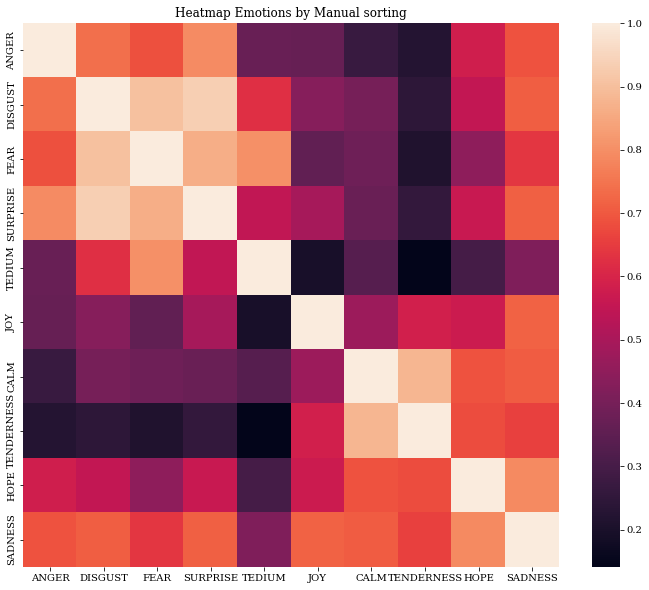

In [65]:
plt.figure(figsize = (12,10))
plt.title('Heatmap Emotions by Manual sorting')
sn.heatmap(cosine_dist_emotions, annot=False, xticklabels=emotions, yticklabels=emotions)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

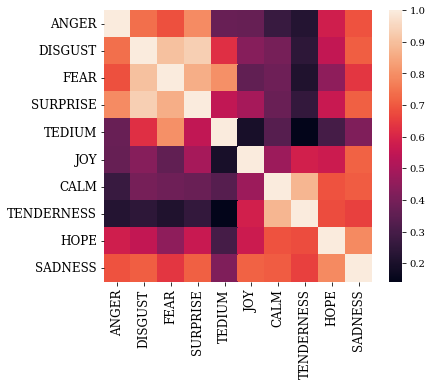

In [67]:
plt.figure(figsize = (6,5))
sn.heatmap(cosine_dist_emotions, annot=False, xticklabels=emotions, yticklabels=emotions)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation = 0)
plt.savefig("heatmap_emotions.png", format="png", bbox_inches="tight")
files.download("heatmap_emotions.png")

### 2.9 Get top acoustic labels per emotion
This function returns the acoustic labels in order of greater percentage of detection for a specific emotion

In [68]:
wordCount_wemac.todense().shape

(43, 351)

In [69]:
sorted_wordCount_wemac = wordCount_wemac.todense()[index_emotion_labels_manual_wo,:]

In [70]:
sorted_wordCount_wemac.shape

(37, 351)

In [71]:
emotion_wordCount_bbdlab = pd.DataFrame(data = np.zeros((10, 351)))
for id, emotion in enumerate(emotions):
  emotion_aux = [correspondence_wemac_sorted_wo['Discrete emotion'] == emotion][0].values
  emotion_idx = correspondence_wemac_sorted_wo[emotion_aux].index.values
  #print(emotion_idx)
  emotion_rows = sorted_wordCount_wemac[emotion_idx,:]
  #print(emotion_rows)
  #print(np.mean(emotion_rows, axis=0).shape)
  emotion_wordCount_bbdlab.iloc[id] = np.sum(emotion_rows, axis=0)

In [72]:
wemac_lengths_list_wo_sorted = [wemac_lengths_list[i] for i in index_emotion_labels_manual_wo]

In [73]:
emotion_lengths = []
for id, emotion in enumerate(emotions):
  emotion_aux = [correspondence_wemac_sorted_wo['Discrete emotion'] == emotion][0].values
  emotion_idx = correspondence_wemac_sorted_wo[emotion_aux].index.values
  emotion_len = [wemac_lengths_list_wo_sorted[i] for i in emotion_idx]
  #emotion_len = wemac_lengths_list_wo_sorted[emotion_idx]
  #print(emotion_len)
  emotion_lengths.append(np.sum(emotion_len))

In [74]:
def percentage_top_labels_per_emotion(data,emotion_lengths,emotions,acoustic_labels,emotion_label):
  percentages =  data / np.asarray(emotion_lengths)[:,None]
  #print(percentages.T)
  perc_df = pd.DataFrame(data = percentages.T.to_numpy(), index = acoustic_labels, columns = emotions)
  #print(perc_df)

  vid_perc = perc_df[emotion_label].sort_values(ascending=False)
  vid_perc_df = pd.DataFrame(vid_perc)
  return vid_perc_df

Exammple with "FEAR" emotion

In [75]:
emotion_to_determine = 'FEAR' # 'ANGER', 'DISGUST', 'FEAR', 'SURPRISE', 'HOPE', 'JOY', 'CALM', 'TENDERNESS', 'TEDIUM', 'SADNESS'
top_labels = percentage_top_labels_per_emotion(emotion_wordCount_bbdlab,emotion_lengths,emotions,df_tfidf_labels_wemac,emotion_to_determine)

In [77]:
top_labels.head(10)

,FEAR
Speech,0.835769
"Inside, large room or hall",0.827418
"Inside, small room",0.798191
"Outside, urban or manmade",0.699374
"Outside, rural or natural",0.693111
Music,0.605428
Animal,0.581072
Vehicle,0.572721
Sound effect,0.539318
Motor vehicle (road),0.472512
